# 9. QLS - Linear Correlation Analysis

## The Correlation Coefficient

Measures the extent to which the relationship between two variables is linear. Its value is always between $-1$ and $1$. A positive coefficient indicates that the variables are directly related. A negative coefficient indicates that they're inversely related. The closer to $0$, the weaker the relationship.

The correlation coefficient of two series $X$ and $Y$ is defined as:

$$r = \frac{Cov(X,Y)}{std(X)std(Y)}$$

Where $Cov$ is the covariance and $std$ is the standard deviation. Two random sets of data will have a correlation coefficient close to $0$.

###  Correlation vs Covariance

Correlation is simply a normalized form of covariance. They are otherwise the same and are often used interchangeably.

#### Covariance Isn't That Meaningful By Itself

Let's say we have two variables $X$ and $Y$ and we take the covariance of the two.

In [19]:
import numpy as np
import pandas as pd
import seaborn as sb
import yfinance as yf

In [20]:
X = np.random.rand(50)
Y = 2 * X + np.random.normal(0, 0.1, 50)

np.cov(X, Y)[0, 1]

0.15306444416314763

So now what? What does this mean? Correlation uses information about the variance of $X$ and $Y$ to normalize this metric. Once we've normalized the metric to the $-1$ to $1$ scale, we can compare correlations.

To see how this is done consider the formula.

$$\frac{Cov(X,Y)}{std(X)std(Y)}$$

$$= \frac{Cov(X,Y)} {\sqrt{var(X)} \sqrt{var(Y)}}$$

$$= \frac{Cov(X,Y)} {\sqrt{Cov(X,X)} \sqrt{Cov(Y,Y)}}$$

To demonstrate this let's compare the correlation and covariance of the two.

In [21]:
X = np.random.rand(50)
Y = 2 * X + 4

print("Covariance of X and Y: \n" + str(np.cov(X, Y)))
print("Correlation of X and Y: \n" + str(np.corrcoef(X, Y)))

Covariance of X and Y: 
[[0.08660427 0.17320854]
 [0.17320854 0.34641709]]
Correlation of X and Y: 
[[1. 1.]
 [1. 1.]]


##### Why do both `np.cov` and `np.corrcoef` return matrices?

The covariance matrix is an important concept in statistics. Often people will refer to the covariance of two variables $X$ and $Y$, but in reality that's just one entry in the covariance matrix.

For each input we have one row and column. The diagonal is the variance of that variable, entries off the diagonal are covariance between different variables. The matrix is symmetric across the diagonal.

In [22]:
cov_matrix = np.cov(X, Y)

# we need to manually set the degrees of freedom on X to 1, as numpy defaults to 0 for variance this is usually fine, but will result in a slight mismatch as np.cov defaults to 1
error = cov_matrix[0, 0] - X.var(ddof=1)

print("Error:", error)

Error: -1.3877787807814457e-17


Correlation: -0.0016968398493803546
Built-in Correlation: -0.0016629030523927476


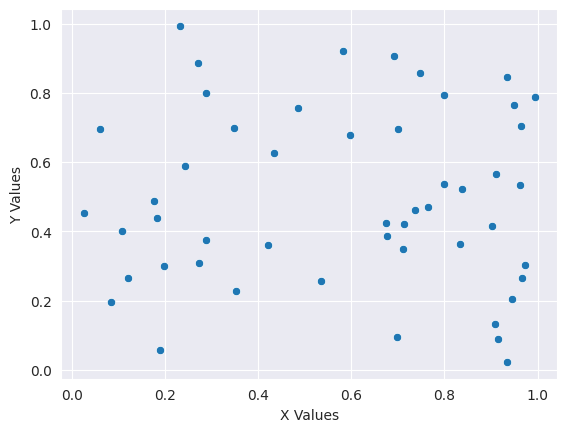

In [23]:
X = np.random.rand(50)
Y = np.random.rand(50)

sb.scatterplot(x=X, y=Y).set(xlabel="X Values", ylabel="Y Values")

# taking the relevant value from the matrix returned by np.cov
print("Correlation:", np.cov(X,Y)[0,1]/(np.std(X)*np.std(Y)))
# Let's also use the builtin correlation function
print("Built-in Correlation:", np.corrcoef(X,Y)[0,1])

Now let's see what two correlated sets of data look like.

Correlation: 0.9414399353839126


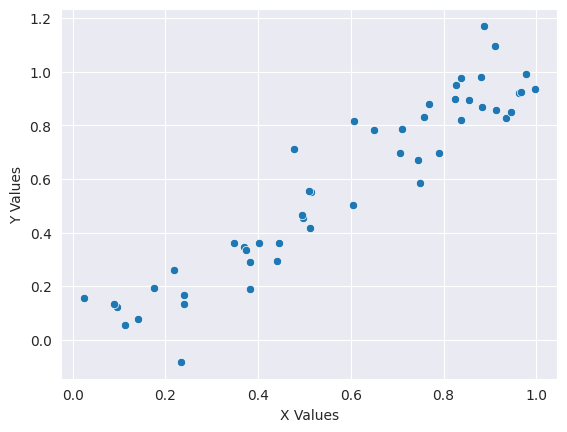

In [24]:
X = np.random.rand(50)
Y = X + np.random.normal(0, 0.1, 50)

sb.scatterplot(x=X, y=Y).set(xlabel="X Values", ylabel="Y Values")

print("Correlation:", np.corrcoef(X,Y)[0,1])

Let's dial down the relationship by introducing more noise.

Correlation: 0.8377722584994041


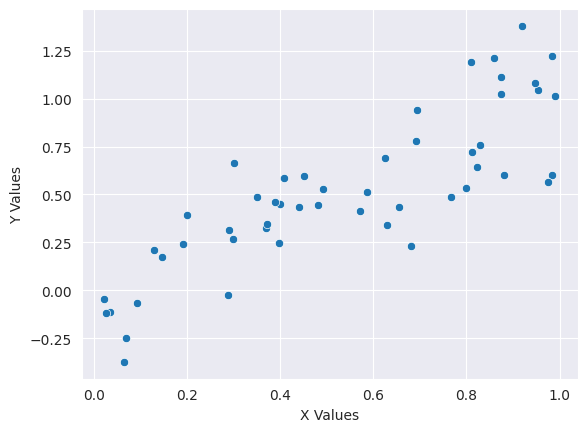

In [25]:
X = np.random.rand(50)
Y = X + np.random.normal(0, .2, 50)

sb.scatterplot(x=X, y=Y).set(xlabel="X Values", ylabel="Y Values")

print("Correlation:", np.corrcoef(X,Y)[0,1])

Finally, let's see what an inverse relationship looks like.

Correlation: -0.9602586214606189


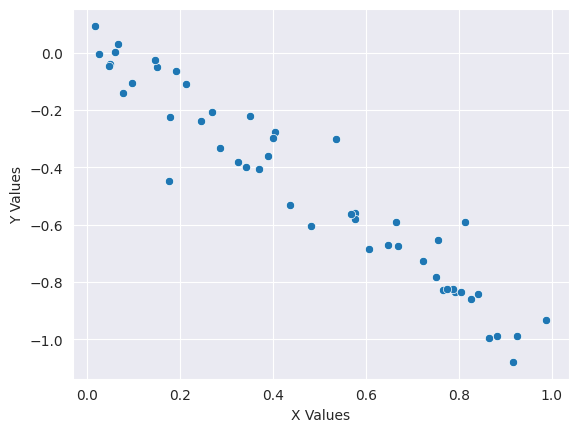

In [26]:
X = np.random.rand(50)
Y = -X + np.random.normal(0, .1, 50)

sb.scatterplot(x=X, y=Y).set(xlabel="X Values", ylabel="Y Values")

print("Correlation:", np.corrcoef(X,Y)[0,1])

### How is this useful in finance?

#### Determining Related Assets

Once we've established that two series are probably related, we can use that to predict future values of a series. For example, let's look at AAPL and a semiconductor manufacturer.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Correlation coefficients
LRCX and AAPL: 0.959501190179656
LRCX and SPY: 0.9390677757784207
AAPL and SPY: 0.9078499519964888


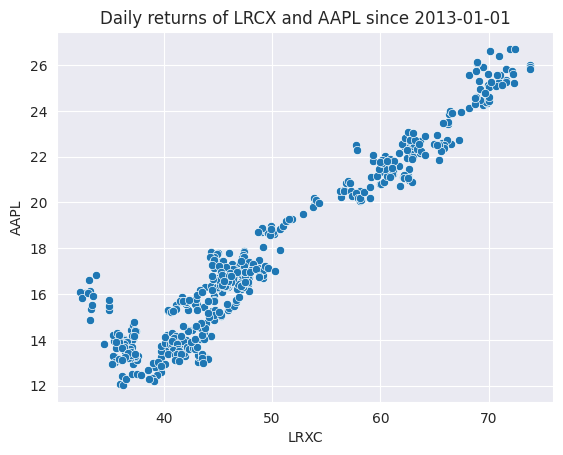

In [27]:
# pull the pricing data for our two equities and SPY
start = "2013-01-01"
end = "2015-01-01"

bench = yf.download("SPY", start, end)
a1 = yf.download("LRCX", start, end)
a2 = yf.download("AAPL", start, end)

bench = bench["Adj Close"]
a1 = a1["Adj Close"]
a2 = a2["Adj Close"]

sb.scatterplot(x=a1, y=a2).set(title=f"Daily returns of LRCX and AAPL since {start}", xlabel="LRXC", ylabel="AAPL")

print("Correlation coefficients")
print("LRCX and AAPL:", np.corrcoef(a1,a2)[0,1])
print("LRCX and SPY:", np.corrcoef(a1,bench)[0,1])
print("AAPL and SPY:", np.corrcoef(bench,a2)[0,1])

#### Constructing a Portfolio of Uncorrelated Assets

Another reason that it's useful in finance is that uncorrelated assets produce the best portfolios. The intuition for this is that if the assets are uncorrelated, a depreciation in one will not correspond with a depreciation in another. This leads to a stable return stream when many are combined.

### Limitations

#### Significance

It's hard to rigorously determine if a correlation is significant, especially when the variables are not normally distributed. Their correlation coefficient is close to 1, so its safe to say that they're correlated for our time period, but will this be true in the future?

One fundamental problem is that it's easy to datamine correlations by picking the right time period. To avoid this we should compute it over large time periods and examine the distribution of the correlation coefficient.

As an example, we take the 60-day correlation between AAPL and LRCX to see how it varies.

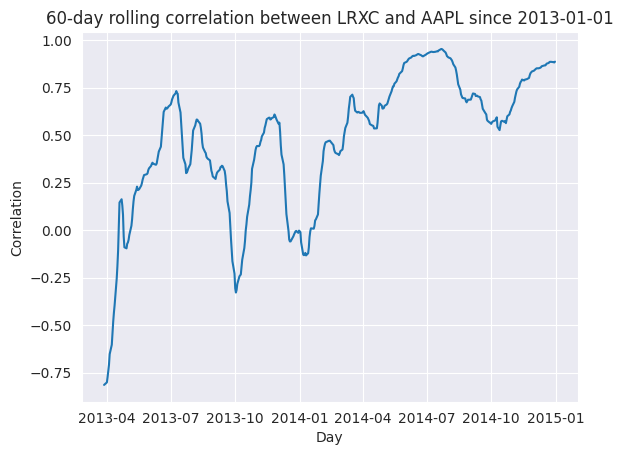

In [28]:
rolling_correlation = a1.rolling(60).corr(a2)
sb.lineplot(rolling_correlation).set(title=f"60-day rolling correlation between LRXC and AAPL since {start}", xlabel="Day", ylabel="Correlation");

#### Non-Linear Relationships

The correlation coefficient can be useful for examining the strength of the relationship between two variables. Two variables might be associated in different, predictable, ways which the analysis doesn't pick up. For example, one might follow the movements of a 2nd but with a delay. Alternatively, one might be related to the ROC of the other. Neither of these are linear, but they're useful if detected.

The correlation coefficient can be sensitive to outliers, meaning that including or excluding a couple of data points can alter the results.

As an example, let's make the noise distribution poisson rather than normal and see what happens.

-0.05303718612247957

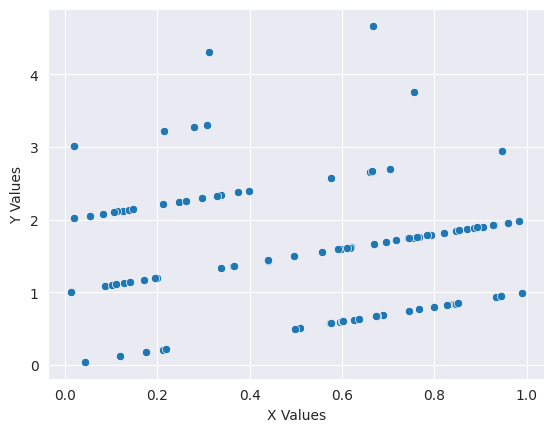

In [29]:
X = np.random.rand(100)
Y = X + np.random.poisson(size=100)

sb.scatterplot(x=X, y=Y).set(xlabel="X Values", ylabel="Y Values")

np.corrcoef(X, Y)[0, 1]

Correlation is a powerful technique, but as always in statistics, we should be careful not to interpret results where there are none.